In [ ]:
!pip install pycaret
!pip install geopandas
!pip install geemap

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import pycaret as car
import geemap
import ee
# import eeconvert

from functools import reduce
from geopandas import GeoDataFrame
from shapely.geometry import Point,Polygon
# from pycaret.utils import enable_colab
# enable_colab()

In [2]:
# ee.Authenticate()
ee.Initialize()

In [3]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

In [4]:
grid = ee.FeatureCollection('users/geethensingh/WTWTA_grid75457')
print(grid.size().getInfo())
# Map.addLayer(grid)

grid_img = grid.reduceToImage(**{'properties': ['fid'], 'reducer': ee.Reducer.first()}).rename('fid')
# Map.addLayer(grid_img)

6


In [5]:
label = ee.ImageCollection.fromImages([ee.Image('users/jdmwhite/UD_buf_mean'),ee.Image('users/geethensingh/UD_buf_GPS')]).mean().rename('label')
covs = ee.Image('users/jdmwhite/WTWTA_covariates_1000_sel').addBands([grid_img, label])
# covs = ee.Image('users/jdmwhite/WTWTA_covariates_1000_sel').addBands([label])
# print(covs.bandNames().getInfo())
pts = ee.FeatureCollection('users/jdmwhite/buff_sampled_points').select([])
print(pts.first().getInfo())

{'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [31.758101185332148, -24.595835104973677]}, 'id': '00000000000000001d2b', 'properties': {}}


In [6]:
print(pts.size().getInfo())
extracted_covs = covs.reduceRegions(**{'collection': pts, 'scale': 1000, 'reducer': ee.Reducer.first()})
print(extracted_covs.size().getInfo())

10491
10491


In [7]:
def largefc_to_pandas(featurecollection, step_size = 5000):
    """
    function to convert a featurecollection with more than 5000 elements to a pandas dataframe
    
    featurecollection: earth engine feature collection with more than 5000 elements
    step_size: Th enumber of elemenst to process at once. Must be less than equal to 5000
    
    """
    df = pd.DataFrame()
    fclist = featurecollection.toList(featurecollection.size())
    fcsize = featurecollection.size().getInfo()
    for i in range(0,fcsize,step_size):
        fc = ee.FeatureCollection(fclist.slice(i,i+step_size))
        df = df.append(geemap.ee_to_pandas(fc))
    return df

df = largefc_to_pandas(extracted)

In [8]:
df  = largefc_to_pandas(extracted_covs)
print(f"There are {len(df)} features")
print(df.info(memory_usage='deep'))
print(df.head(5))

There are 10491 features
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10491 entries, 0 to 490
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   b1      10116 non-null  float64
 1   b10     10116 non-null  float64
 2   b11     10116 non-null  float64
 3   b12     10116 non-null  float64
 4   b13     10116 non-null  float64
 5   b14     10116 non-null  float64
 6   b15     10116 non-null  float64
 7   b16     10116 non-null  float64
 8   b17     10116 non-null  float64
 9   b18     10116 non-null  float64
 10  b19     10116 non-null  float64
 11  b2      10116 non-null  float64
 12  b20     10116 non-null  float64
 13  b21     10116 non-null  float64
 14  b22     10027 non-null  float64
 15  b23     10116 non-null  float64
 16  b24     10116 non-null  float64
 17  b25     10116 non-null  float64
 18  b26     10116 non-null  float64
 19  b27     10116 non-null  float64
 20  b28     10116 non-null  float64
 21  b3      1011

In [27]:
list = []
for i in range(1,46):
    list.append('b'+ str(i))
    
print(list)

['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b13', 'b14', 'b15', 'b16', 'b17', 'b18', 'b19', 'b20', 'b21', 'b22', 'b23', 'b24', 'b25', 'b26', 'b27', 'b28', 'b29', 'b30', 'b31', 'b32', 'b33', 'b34', 'b35', 'b36', 'b37', 'b38', 'b39', 'b40', 'b41', 'b42', 'b43', 'b44', 'b45']


In [28]:
df_lgmb = df[['label','fid', *list]]

In [31]:
colnames = ['CHILI','H_bed_depth','urban.coverfraction','corr','uniformity','H_fcc','slope','H_carb_org','H_clay','H_text_class','cti','tpi','SANLC','bare.coverfraction','water.seasonal.coverfraction','bio_annP','evi_winter','H_stone','canopy_height','wp','BurnDate_count','SF','grass.coverfraction','tree.coverfraction','elevation','bio_minT','distance_trans_lines','distance_settlements','osm_water','change_abs','change_norm','wcsat','crops.coverfraction','shrub.coverfraction','variance','simpson','stc','N','transition','water.permanent.coverfraction','recurrence','seasonality','distance_roads','spi','bio_Pdq']

In [33]:
df_lgmb.columns = ['label','fid', *colnames]
df_lgmb.columns

Index(['label', 'fid', 'CHILI', 'H_bed_depth', 'urban.coverfraction', 'corr',
       'uniformity', 'H_fcc', 'slope', 'H_carb_org', 'H_clay', 'H_text_class',
       'cti', 'tpi', 'SANLC', 'bare.coverfraction',
       'water.seasonal.coverfraction', 'bio_annP', 'evi_winter', 'H_stone',
       'canopy_height', 'wp', 'BurnDate_count', 'SF', 'grass.coverfraction',
       'tree.coverfraction', 'elevation', 'bio_minT', 'distance_trans_lines',
       'distance_settlements', 'osm_water', 'change_abs', 'change_norm',
       'wcsat', 'crops.coverfraction', 'shrub.coverfraction', 'variance',
       'simpson', 'stc', 'N', 'transition', 'water.permanent.coverfraction',
       'recurrence', 'seasonality', 'distance_roads', 'spi', 'bio_Pdq'],
      dtype='object')

In [34]:
df_lgmb.shape

(10491, 47)

In [35]:
df_lgmb = df_lgmb.fillna(0)

In [36]:
df_lgmb.isna().sum()

label                            0
fid                              0
CHILI                            0
H_bed_depth                      0
urban.coverfraction              0
corr                             0
uniformity                       0
H_fcc                            0
slope                            0
H_carb_org                       0
H_clay                           0
H_text_class                     0
cti                              0
tpi                              0
SANLC                            0
bare.coverfraction               0
water.seasonal.coverfraction     0
bio_annP                         0
evi_winter                       0
H_stone                          0
canopy_height                    0
wp                               0
BurnDate_count                   0
SF                               0
grass.coverfraction              0
tree.coverfraction               0
elevation                        0
bio_minT                         0
distance_trans_lines

In [37]:
pd.Series(df.fid).shape

(10491,)

In [38]:
train = df_lgmb[df_lgmb.fid>0]
train.shape
test = df_lgmb[df_lgmb.fid<1]
test.fid.value_counts()

0    2284
Name: fid, dtype: int64

In [39]:
from pycaret.regression import *
exp_reg101 = setup(data = train.drop(['fid'],axis=1), test_data = test.drop(['fid'],axis=1), target = 'label', fold = 5, fold_strategy = 'groupkfold', fold_groups = pd.Series(train.fid),\
categorical_imputation = 'constant', numeric_imputation = 'mean',\
session_id=42)

,Description,Value
0,session_id,42
1,Target,label
2,Original Data,"(8207, 46)"
3,Missing Values,False
4,Numeric Features,45
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(8207, 43)"


In [40]:
best = compare_models(errors="raise")

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0273,0.0019,0.0388,-0.0246,0.0359,227798.3546,3.0960
lightgbm,Light Gradient Boosting Machine,0.0270,0.0020,0.0397,-0.2029,0.0366,229864.6899,0.1720
lasso,Lasso Regression,0.0300,0.0026,0.0458,-0.3529,0.0417,513798.4639,1.3840
en,Elastic Net,0.0300,0.0026,0.0458,-0.3764,0.0416,408515.0784,0.0320
xgboost,Extreme Gradient Boosting,0.0297,0.0022,0.0419,-0.4532,0.0387,241369.4642,1.0900
et,Extra Trees Regressor,0.0278,0.0017,0.0377,-0.7289,0.0351,229038.7418,0.8900
gbr,Gradient Boosting Regressor,0.0313,0.0024,0.0442,-0.7885,0.0408,311860.4907,0.8380
rf,Random Forest Regressor,0.0283,0.0019,0.0406,-0.8631,0.0376,229587.5914,1.7340
omp,Orthogonal Matching Pursuit,0.0316,0.0025,0.0462,-1.6641,0.0421,1679311.0106,0.0340
llar,Lasso Least Angle Regression,0.0345,0.0029,0.0491,-1.7654,0.0452,4730142.3363,0.0320


In [41]:
et = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0374,0.0027,0.0519,0.1569,0.0480,70037.7602
1,0.0270,0.0018,0.0420,0.2112,0.0392,1026286.1852
2,0.0426,0.0031,0.0554,0.4995,0.0498,48851.0978
3,0.0197,0.0005,0.0221,-5.0674,0.0217,11.6890
4,0.0124,0.0003,0.0173,0.5556,0.0166,6.9768
Mean,0.0278,0.0017,0.0377,-0.7289,0.0351,229038.7418
SD,0.0111,0.0011,0.0154,2.1748,0.0136,399565.0950


In [42]:
tune_et = tune_model(et)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.0272,0.0034,0.0587,-0.0797,0.0533,160133.2628
1,0.0215,0.0022,0.0472,0.0049,0.0431,908489.7337
2,0.0488,0.0080,0.0893,-0.3000,0.0800,97921.7564
3,0.0051,0.0001,0.0080,0.2064,0.0078,3.0782
4,0.0155,0.0008,0.0278,-0.1461,0.0266,3.1452
Mean,0.0236,0.0029,0.0462,-0.0629,0.0422,233310.1952
SD,0.0146,0.0028,0.0276,0.1677,0.0244,343050.0525


In [43]:
final_et = finalize_model(tune_et)

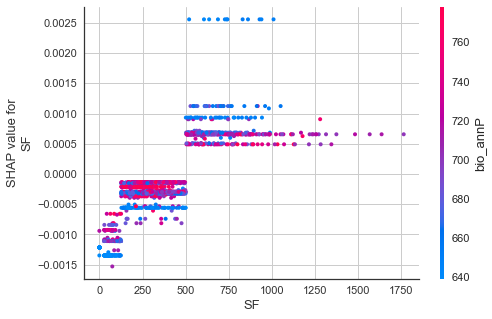

In [51]:
interpret_model(final_et, plot = "correlation", feature = 'SF', observation = None)

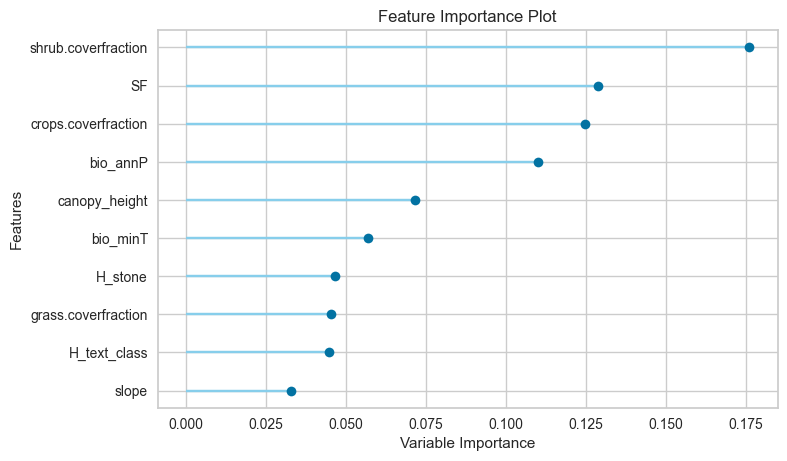

In [44]:
plot_model(final_et,'feature')
plt.savefig()

In [20]:
save_model(final_et,'D:\My_projects\Rhinos_KNP\Final ET Model 04_Aug_2021')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='label',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='...
                  ExtraTreesRegressor(bootstrap=True, ccp_alpha=0.0,
                                      criterion='mae', max_depth=11,
                                      max_features='log2', max_leaf_nodes=None,
                                      max_samples=None,
                                      m

In [33]:
from ngboost import NGBRegressor
ngb = NGBRegressor()